## shifting added (-0.1, 0.1)
## train data = policy applied simulation data

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


# read data

In [11]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
print(df_all.shape)
print(df_all.columns)

(610615, 12)
Index(['time_index', 'melt_pool_temperature', 'melt_pool_depth',
       'scanning_speed', 'X', 'Y', 'Z', 'Dist_to_nearest_X',
       'Dist_to_nearest_Y', 'Dist_to_nearest_Z', 'Laser_power',
       'laser_power_number'],
      dtype='object')


In [6]:
# nan_rows = df_all[df_all.isna().any(axis=1)]
# df_all = df_all.dropna()

target_range = range(2, 100)

for num in target_range:
    count = len(df_all[df_all['laser_power_number'] == num])
    if count != 6295:
        print(f"laser_power_number = {num}: {count} rows")

laser_power_number = 80: 0 rows


## preprocess data for training

In [12]:
# global min/max for normalization
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)

mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)

x_original_all = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_all = np.concatenate((mp_temp, mp_depth), axis=1)

x_max = np.max(x_original_all,0).reshape(1,-1)
x_min = np.min(x_original_all,0).reshape(1,-1)

y_max = np.array([[4509.855, 0.551]])  # [melt_pool_temp_max, depth_max]
y_min = np.array([[436.608, -0.559]])  # [melt_pool_temp_min, depth_min]

print("x_max:", x_max)
print("x_min:", x_min)
print("y_max:", y_max)
print("y_min:", y_min)

# scaler class
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min

    def scaler_x(self, x_original, dim_id=-1):
        if dim_id == -1:
            return -1 + 2 * ((x_original - self.x_min) / (self.x_max - self.x_min))
        else:
            return -1 + 2 * ((x_original - self.x_min[0, dim_id]) / (self.x_max[0, dim_id] - self.x_min[0, dim_id]))

    def scaler_y(self, y_original):
        y_original = np.array(y_original)
        assert y_original.shape[1] == 2, f"Expected y_original shape (_,2), got {y_original.shape}"
        diff = self.y_max - self.y_min
        return -1 + 2 * ((y_original - self.y_min) / diff)

scaler = scalers(x_max, x_min, y_max, y_min)

window = 50
P = 50



x_max: [[  7.5         20.          20.         732.29754489]]
x_min: [[  0.           0.75         0.75       504.25290881]]
y_max: [[4.509855e+03 5.510000e-01]]
y_min: [[436.608  -0.559]]


In [16]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader

train_datasets = []
val_datasets = []

for n in range(2, 50):
    df_n = df_all[df_all["laser_power_number"] == n].reset_index(drop=True)
    if len(df_n) < window + P:
        continue

    # input features
    loc_Z = df_n["Z"].to_numpy().reshape(-1,1)
    dist_X = df_n["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
    dist_Y = df_n["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
    laser_power = df_n["Laser_power"].to_numpy().reshape(-1,1)
    x_original = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)

    # output labels
    mp_temp_raw = df_n["melt_pool_temperature"].to_numpy()
    mp_temp_mv = moving_average_1d(mp_temp_raw, 4)
    mp_temp = copy.deepcopy(mp_temp_raw)
    mp_temp[1:-2] = mp_temp_mv
    mp_temp = mp_temp.reshape(-1,1)

    mp_depth_raw = df_n["melt_pool_depth"].to_numpy()
    mp_depth_mv = moving_average_1d(mp_depth_raw, 4)
    mp_depth = copy.deepcopy(mp_depth_raw)
    mp_depth[1:-2] = mp_depth_mv
    mp_depth = mp_depth.reshape(-1,1)

    y_original = np.concatenate((mp_temp, mp_depth), axis=1)
    x_s = scaler.scaler_x(x_original)
    y_s = scaler.scaler_y(y_original)

    length = y_s.shape[0]
    e = 0.001
    y_depth_low = np.random.uniform(0.1423-e, 0.1423+e, size=(length, 1))
    y_depth_up = np.random.uniform(0.4126-e, 0.4126+e, size=(length, 1))
    y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

    try:
        u_sim_raw = np.genfromtxt(
            f"/home/ftk3187/github/DPC_research/02_DED/2_policy/simulation_outputs/u_outputs_laser_{n}.csv",
            delimiter=",", dtype=float, filling_values=np.nan
        )
        x_sim_raw = np.genfromtxt(
            f"/home/ftk3187/github/DPC_research/02_DED/2_policy/simulation_outputs/x_outputs_laser_{n}.csv",
            delimiter=",", dtype=float, filling_values=np.nan
        )
    except FileNotFoundError:
        print(f"File not found for laser power {n}. Skipping...")
        continue

    try:
        u_sim_norm = scaler.scaler_x(u_sim_raw.reshape(-1,1), dim_id=3).reshape(-1)
        y_sim_raw = x_sim_raw[:, :2]
        y_sim_norm = scaler.scaler_y(y_sim_raw)
        x_temp_norm = y_sim_norm[:, 0]
        x_depth_norm = y_sim_norm[:, 1]
    except:
        continue

    # group-wise sequence containers
    group_x_past, group_y_past = [], []
    group_x_future, group_y_ref, group_y_const = [], [], []

    for i in range(window, len(x_s) - P - 10):
        x_past = x_s[i - window:i].copy()
        y_past = y_s[i - window:i].copy()
        x_future = x_s[i:i + P, :3]

        x_past[:, 3] = u_sim_norm[i - window:i]
        y_past[:, 0] = x_temp_norm[i - window:i]
        y_past[:, 1] = x_depth_norm[i - window:i]

        y_ref = y_s[i:i + P, :1]
        y_const = y_s_const[i:i + P]

        group_x_past.append(x_past)
        group_y_past.append(y_past)
        group_x_future.append(x_future)
        group_y_ref.append(y_ref)
        group_y_const.append(y_const)

    if len(group_x_past) == 0:
        continue

    dataset_n = TensorDataset(
        torch.tensor(np.stack(group_x_past), dtype=torch.float32),
        torch.tensor(np.stack(group_y_past), dtype=torch.float32),
        torch.tensor(np.stack(group_x_future), dtype=torch.float32),
        torch.tensor(np.stack(group_y_ref), dtype=torch.float32),
        torch.tensor(np.stack(group_y_const), dtype=torch.float32),
    )

    if n <= 35:
        train_datasets.append(dataset_n)
    else:
        val_datasets.append(dataset_n)

batch_size = 512
# Final concatenation
train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())
print(f'Total number of parameters: {total_params}')
print(TiDE)

# Extract model dimensions
input_chunk_length = TiDE.input_chunk_length
output_chunk_length = TiDE.output_chunk_length
input_dim = TiDE.input_dim
output_dim = TiDE.output_dim
past_cov_dim = TiDE.past_cov_dim
future_cov_dim = TiDE.future_cov_dim
static_cov_dim = TiDE.static_cov_dim
nr_params = TiDE.nr_params

print("input_chunk_length:", input_chunk_length)
print("output_chunk_length:", output_chunk_length)
print("input_dim:", input_dim)
print("output_dim:", output_dim)
print("past_cov_dim:", past_cov_dim)
print("future_cov_dim:", future_cov_dim)
print("static_cov_dim:", static_cov_dim)
print("nr_params:", nr_params)

# Generate dummy input
B = 1  # batch size
x_past = torch.randn(B, input_chunk_length, input_dim)
x_future_covariates = torch.randn(B, output_chunk_length, future_cov_dim) if future_cov_dim > 0 else None
x_static_covariates = torch.randn(B, static_cov_dim) if static_cov_dim > 0 else None

# Move to device
x_past = x_past.to(device)
if x_future_covariates is not None:
    x_future_covariates = x_future_covariates.to(device)
if x_static_covariates is not None:
    x_static_covariates = x_static_covariates.to(device)

# Run model
x_in = (x_past, x_future_covariates, x_static_covariates)
y = TiDE(x_in)

# Print shapes
print("Input shape:")
print("  x_past:", x_past.shape)
if x_future_covariates is not None:
    print("  x_future_covariates:", x_future_covariates.shape)
if x_static_covariates is not None:
    print("  x_static_covariates:", x_static_covariates.shape)

print("Output shape:", y.shape)  # (B, output_chunk_length, output_dim, nr_params)

Total number of parameters: 796594
TideModule(
  (future_cov_projection): ResidualBlock(
    (dense): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=4, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (skip): Linear(in_features=4, out_features=4, bias=True)
    (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
  (encoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (skip): Linear(in_features=500, out_features=128, bias=True)
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=128, out_features=128,

# loss function


In [22]:
## loss on initial 10 steps

def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0.1, w_constraint=3.0):
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2

    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    # u_diff_2 = x_past[:, -1, 3] - u_output[:,   0, :] ## added for smoothness loss
    smoothness_loss = u_diff ** 2 
    # smoothness_loss_2 = u_diff_2 ** 2

    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = 0 * low_violation + up_violation

    loss = (
        w_tracking * torch.sqrt(tracking_loss.mean()) +
        w_smooth * (torch.sqrt(smoothness_loss.mean())) + # +torch.sqrt(smoothness_loss_2.mean())) +
        w_constraint * torch.sqrt(constraint_loss.mean())
    )
    return loss


In [23]:
import pickle
import os

def train_and_evaluate(n_layers, hidden_dim, setting_name,
                       w_smooth, w_constraint):
    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout_p=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    counter = 0

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        model.train()
        for epoch in range(num_epoch):

            for x_past, y_past, x_future, y_ref, y_const in train_loader:
                x_past, y_past, x_future, y_ref, y_const = (
                    x_past.to(device), y_past.to(device),
                    x_future.to(device), y_ref.to(device), y_const.to(device)
                )

                policy_in_past = torch.cat((x_past, y_past), dim=2)
                policy_in_future = torch.cat((x_future, y_ref, y_const), dim=2)

                optimizer.zero_grad()

                u_output = model((policy_in_past, policy_in_future))
                x_future_tide = torch.cat((x_future, u_output), dim=2)
                past_cov = torch.cat((y_past, x_past), dim=2)

                tide_pred = TiDE((past_cov, x_future_tide, None))
                loss = DPC_loss(x_past, tide_pred, y_ref, u_output, y_const,
                                w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                loss.backward()
                optimizer.step()

            # validation
            model.eval()
            val_loss_total = 0.0
            num_val_batches = 0

            with torch.no_grad():
                for val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const in val_loader:
                    val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const = (
                        val_x_past.to(device), val_y_past.to(device),
                        val_x_future.to(device), val_y_ref.to(device), val_y_const.to(device)
                    )

                    val_policy_in_past = torch.cat((val_x_past, val_y_past), dim=2)
                    val_policy_in_fut = torch.cat((val_x_future, val_y_ref, val_y_const), dim=2)

                    val_u_output = model((val_policy_in_past, val_policy_in_fut))

                    x_future_tide_val = torch.cat((val_x_future, val_u_output), dim=2)
                    past_cov_val = torch.cat((val_y_past, val_x_past), dim=2)

                    val_tide_pred = TiDE((past_cov_val, x_future_tide_val, None))
                    val_loss = DPC_loss(val_x_past, val_tide_pred, val_y_ref, val_u_output, val_y_const,
                                        w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                    val_loss_total += val_loss.item()
                    num_val_batches += 1

            val_loss_avg = val_loss_total / num_val_batches

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss_avg
            scheduler.step()
            pbar.set_description(f"{setting_name} | Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss_avg:.4f}")
            pbar.update(1)


    # directory where you want to store all results
    train_dir = "/home/ftk3187/github/DPC_research/02_DED/2_policy/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # build filename and full path
    model_filename = f"policy_model_0722_shift0.1_{setting_name}.pth"
    model_path = os.path.join(train_dir, model_filename)

    # save and report
    torch.save(best_model, model_path)
    print(f"Saved model to: {model_path}")

    # Save model parameters as .pkl
    model_params = {
        "model_name": setting_name,
        "past_input_dim": 6,
        "future_input_dim": 6,
        "output_dim": 1,
        "future_cov_dim": 2,
        "static_cov_dim": 0,
        "window": 50,
        "p": 50,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epoch": num_epoch,
        "w_smooth": w_smooth,
        "w_constraint": w_constraint
    }

    train_dir = "/home/ftk3187/github/DPC_research/02_DED/2_policy/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # save model parameters
    param_filename = f"policy_parameters_0722_shift0.1_{setting_name}.pkl"
    param_path = os.path.join(train_dir, param_filename)
    with open(param_path, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Saved model parameters to: {param_path}")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss
    }


In [ ]:
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pickle

# Hyperparameters
num_epoch = 50
learning_rate = 1e-4
weight_decay = 1e-5
patience = 100

target_configs = [
    (3, 1024, 1, 3),  # s0c0
]

# Results dictionary
results = {}

# Run training for each configuration
for n_layers, hidden_dim, w_smooth, w_constraint in target_configs:
    setting_name = f"{n_layers}L_{hidden_dim}H_s{w_smooth}_c{w_constraint}"
    print(f"\n▶ Training model: {setting_name}")

    result = train_and_evaluate(
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        setting_name=setting_name,
        w_smooth=w_smooth,
        w_constraint=w_constraint
    )
    results[setting_name] = result



▶ Training model: 3L_1024H_s1_c3


3L_1024H_s1_c3 | Epoch 44 | Train: 0.2384 | Val: 0.2213:  90%|█████████ | 45/50 [06:28<00:41,  8.33s/it]

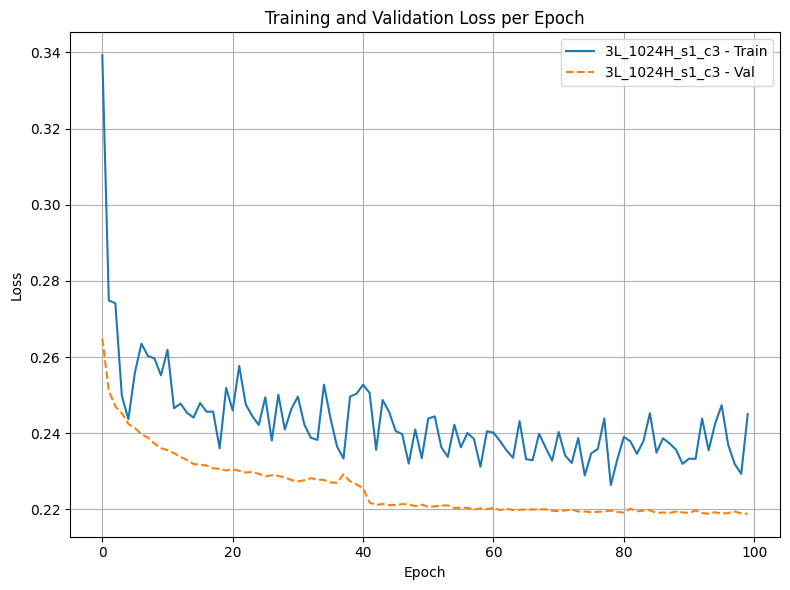

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for setting_name, result in results.items():
    plt.plot(result['train_loss'], label=f"{setting_name} - Train")
    plt.plot(result['val_loss'], label=f"{setting_name} - Val", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
